# Puma 560 - Square path

## Moran Garcia Daniel - Brunett Chavez Lex - Delgado Zambrano Jose - Trivino Gonzalez Hector

### Import libraries

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from math import pi
from spatialmath import *
from spatialmath.base import *

### Analysis of trapezoidal and polynomial interpolation

In [2]:
steps = 100
max_val = 10
min_val = 0

step = (max_val - min_val)/steps

tp = rtb.lspb(min_val, max_val, steps)
pol = rtb.tpoly(min_val, max_val, steps)
step_series = np.arange(min_val, steps, 1)

def graph_curve(title, step_series, pol_curve, tp_curve):
    plt.title(title)
    plt.plot(step_series, pol_curve, label="polinomial")
    plt.plot(step_series, tp_curve, label="traprezoidal")
    plt.legend(framealpha=1, frameon=True)

<IPython.core.display.Javascript object>


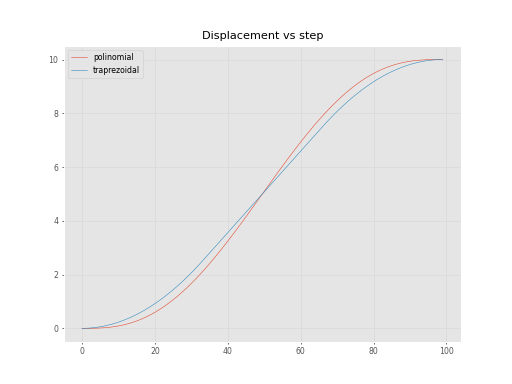

In [3]:
# Displacement vs time
graph_curve("Displacement vs step", step_series, pol.q, tp.q)

<IPython.core.display.Javascript object>


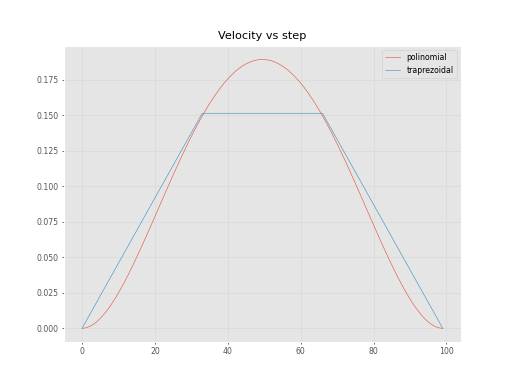

In [4]:
# Velocity vs time
graph_curve("Velocity vs step", step_series, pol.qd, tp.qd)

<IPython.core.display.Javascript object>


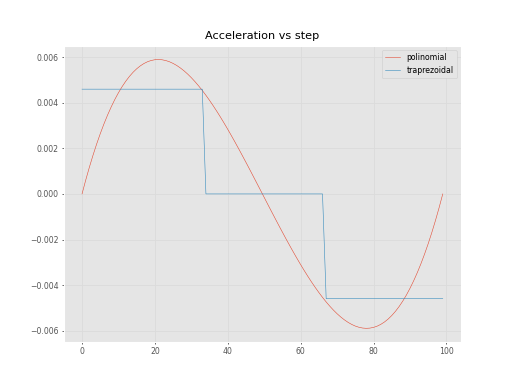

In [5]:
# Acceleration vs time
graph_curve("Acceleration vs step", step_series, pol.qdd, tp.qdd)

### Constants definition

In [9]:
# The following coordinates are the vertix of the square
A_coord = {"x": 0.3, "y": 0.15, "z": 0}
B_coord = {"x": 0.15, "y": 0.15, "z": 0}
C_coord = {"x": 0.15, "y": 0.3, "z": 0}
D_coord = {"x": 0.3, "y": 0.3, "z": 0}

STEPS = 20
STEP_SERIES = np.arange(0, STEPS * 4, 1) # STEPS times 4 due to working with 4 paths
puma = rtb.models.DH.Puma560()

In [11]:
def get_SE3_matrix(coordinates):
    return SE3(coordinates["x"], coordinates["y"], coordinates["z"])

def get_trap_path(c_A, c_B, int_type):
    path = {}
    if(len(c_A) == len(c_B)):
        for key in c_A:
            if(c_A[key] != c_B[key]):
                tp = []
                if int_type == "trap":
                    tp = rtb.lspb(c_A[key], c_B[key], STEPS)
                elif int_type == "poli":
                    tp = rtb.tpoly(c_A[key], c_B[key], STEPS)
                path[key] = tp
            else:
                path[key] = c_A[key]
    return path

def get_trj_coord(path):
    tj_dis = []
    tj_vel = []
    tj_acc = []
    for key in path:
        if isinstance(path[key], int) or isinstance(path[key], float):
            tj_dis.append(np.full((1, STEPS), path[key])[0])
            tj_vel.append(np.zeros(STEPS))
            tj_acc.append(np.zeros(STEPS))
        else:
            tj_dis.append(path[key].q)
            tj_vel.append(path[key].qd)
            tj_acc.append(path[key].qdd)
    tj_dis = np.array(tj_dis)
    tj_vel = np.array(tj_vel)
    tj_acc = np.array(tj_acc)
    return {"q": tj_dis.transpose(), "qd": tj_vel.transpose(), "qdd": tj_acc.transpose()}

def ikin_from_trj_coord(trj):
    inverse_kin_trj = []
    for ind_trj in trj:
        coord = {"x": ind_trj[0], "y": ind_trj[1], "z": ind_trj[2]}
        ikin = puma.ikine_min(get_SE3_matrix(coord))
        inverse_kin_trj.append(ikin.q)
    return np.array(inverse_kin_trj)

def get_ikin(coord_0, coord_1, int_type):
    path = get_trap_path(coord_0, coord_1, int_type)
    motion_traj = get_trj_coord(path)
    return ikin_from_trj_coord(motion_traj["q"])

def get_general_traj(int_type):
    ikin_trjAB = get_ikin(A_coord, B_coord, int_type)
    ikin_trjBC = get_ikin(B_coord, C_coord, int_type)
    ikin_trjCD = get_ikin(C_coord, D_coord, int_type)
    ikin_trjDA = get_ikin(D_coord, A_coord, int_type)

    ikin_trjAC = np.concatenate((ikin_trjAB, ikin_trjBC), axis=0)
    ikin_trjCA = np.concatenate((ikin_trjCD, ikin_trjDA), axis=0)
    return np.concatenate((ikin_trjAC, ikin_trjCA), axis=0)

def get_motion_traj(int_type):
    dis = []
    vel = []
    acc = []
    pathAB = get_trap_path(A_coord, B_coord, int_type)
    pathBC = get_trap_path(B_coord, C_coord, int_type)
    pathCD = get_trap_path(C_coord, D_coord, int_type)
    pathDA = get_trap_path(D_coord, A_coord, int_type)
    
    kin_traj_AB = get_trj_coord(pathAB)
    kin_traj_BC = get_trj_coord(pathBC)
    kin_traj_CD = get_trj_coord(pathCD)
    kin_traj_DA = get_trj_coord(pathDA)
    
    AC_dis = np.concatenate((kin_traj_AB["q"], kin_traj_BC["q"]), axis = 0)
    CA_dis = np.concatenate((kin_traj_CD["q"], kin_traj_DA["q"]), axis = 0)
    dis = np.concatenate((AC_dis, CA_dis), axis = 0)
    
    AC_vel = np.concatenate((kin_traj_AB["qd"], kin_traj_BC["qd"]), axis = 0)
    CA_vel = np.concatenate((kin_traj_CD["qd"], kin_traj_DA["qd"]), axis = 0)
    vel = np.concatenate((AC_vel, CA_vel), axis = 0)
    
    AC_acc = np.concatenate((kin_traj_AB["qdd"], kin_traj_BC["qdd"]), axis = 0)
    CA_acc = np.concatenate((kin_traj_CD["qdd"], kin_traj_DA["qdd"]), axis = 0)
    acc = np.concatenate((AC_acc, CA_acc), axis = 0)
    
    return {"q": dis, "qd": vel, "qdd": acc}

def graph_curve_coord(STEP_SERIES, trapezoidal_motion, polinomial_motion, kin_type):
    fig, axs = plt.subplots(2)
    title_type = ""
    if kin_type == "q":
        title_type = "Displacement"
    elif kin_type == "qd":
        title_type = "Velocity"
    else:
        title_type = "Acceleration"
    axs[0].set_title(title_type + " vs step (Polinomial)")
    axs[1].set_title(title_type + " vs step (Trapezoidal)")
    axs[0].plot(STEP_SERIES, polinomial_motion[kin_type].transpose()[0], label="x")
    axs[1].plot(STEP_SERIES, trapezoidal_motion[kin_type].transpose()[0], label="x")
    axs[0].plot(STEP_SERIES, polinomial_motion[kin_type].transpose()[1], label="y")
    axs[1].plot(STEP_SERIES, trapezoidal_motion[kin_type].transpose()[1], label="y")
    axs[0].plot(STEP_SERIES, polinomial_motion[kin_type].transpose()[2], label="z")
    axs[1].plot(STEP_SERIES, trapezoidal_motion[kin_type].transpose()[2], label="z")
    axs[1].legend(framealpha=1, frameon=True)
    axs[0].legend(framealpha=1, frameon=True)

<IPython.core.display.Javascript object>


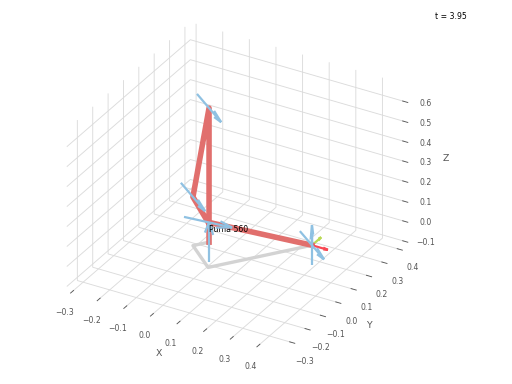

PyPlot3D backend, t = 3.999999999999994, scene:
  Puma 560

In [13]:
trap_traj = get_general_traj("trap")
puma.plot(trap_traj, movie="trapezoidal_path.gif")

<IPython.core.display.Javascript object>


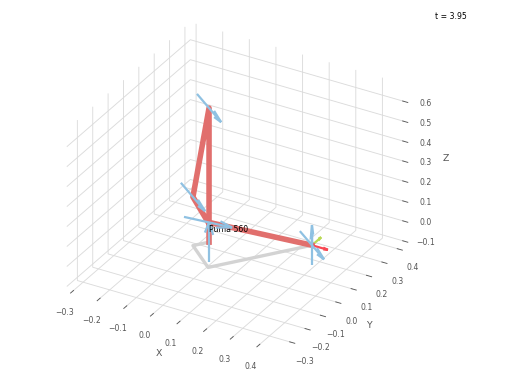

PyPlot3D backend, t = 3.999999999999994, scene:
  Puma 560

In [14]:
poli_traj = get_general_traj("poli")
puma.plot(poli_traj, movie="polinomial_path.gif")

<IPython.core.display.Javascript object>


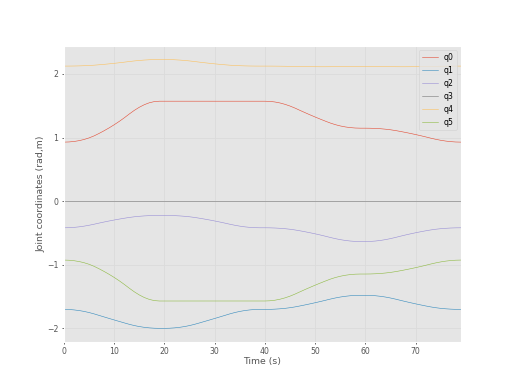

[<AxesSubplot:xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [16]:
# Joint displacement with trapezoidal path
rtb.tools.trajectory.qplot(trap_traj, block=True)

<IPython.core.display.Javascript object>


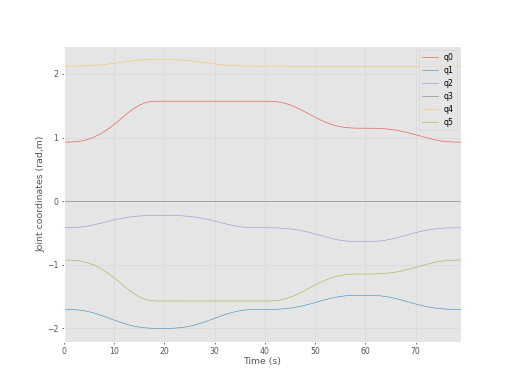

[<AxesSubplot:xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [17]:
# Joint displacement with polynomial path
rtb.tools.trajectory.qplot(poli_traj, block=True)

In [18]:
trapezoidal_motion = get_motion_traj("trap")
polinomial_motion = get_motion_traj("poli")

<IPython.core.display.Javascript object>


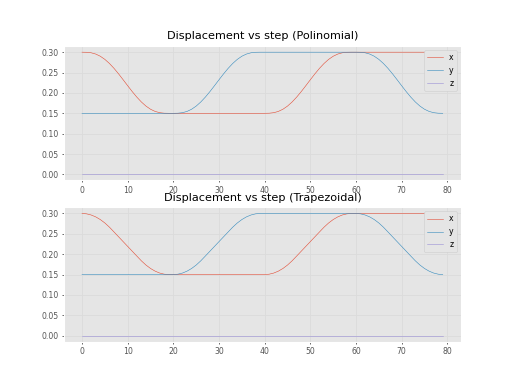

In [19]:
graph_curve_coord(STEP_SERIES, trapezoidal_motion, polinomial_motion, "q")

<IPython.core.display.Javascript object>


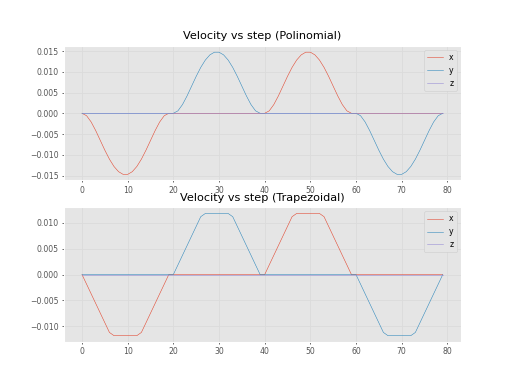

In [83]:
graph_curve_coord(STEP_SERIES, trapezoidal_motion, polinomial_motion, "qd")

<IPython.core.display.Javascript object>


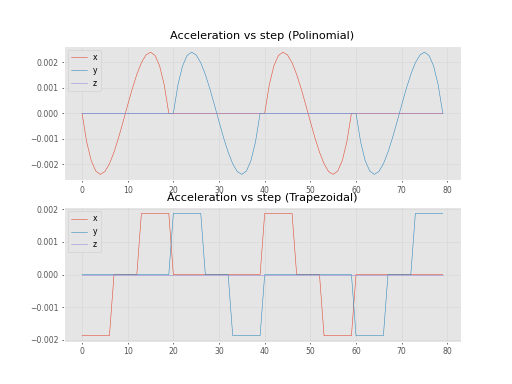

In [84]:
graph_curve_coord(STEP_SERIES, trapezoidal_motion, polinomial_motion, "qdd")